connect google colab with google drive

In [ ]:
#connect google colab with google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#import the libraries to load dataset
import zipfile
import os

#opens file in readmode
zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/MajorProject/br35hdataset/train.zip')

#extracts the files into the /MajorProject folder
zip_ref.extractall('/content/gdrive/MyDrive/MajorProject/br35hdataset')

#close the file
zip_ref.close()

In [ ]:
#import the libraries to load dataset
import zipfile
import os

#opens file in readmode
zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/MajorProject/br35hdataset/validation.zip')

#extracts the files into the /MajorProject folder
zip_ref.extractall('/content/gdrive/MyDrive/MajorProject/br35hdataset')

#close the file
zip_ref.close()

In [ ]:
#import the libraries to load dataset
import zipfile
import os

#opens file in readmode
zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/MajorProject/br35hdataset/test.zip')

#extracts the files into the /MajorProject folder
zip_ref.extractall('/content/gdrive/MyDrive/MajorProject/br35hdataset')

#close the file
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import f1_score
#from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import time
import sys
import math
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from sklearn import svm

In [ ]:
#initializing variables
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30
num_classes=2

In [ ]:
# Enable eager execution
tf.config.run_functions_eagerly(True)

In [ ]:
# Function to preprocess image
def preprocess_image(image_path):
    # Read image
    image = cv2.imread(image_path)
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Blur image
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    # Threshold image to binary
    _, threshold_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # Erosion and Dilation for noise removal
    kernel = np.ones((5,5), np.uint8)
    opening = cv2.morphologyEx(threshold_image, cv2.MORPH_OPEN, kernel)
    # Find contours and select the largest contour
    contours, _ = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    # Calculate extreme points of the contour
    leftmost = tuple(largest_contour[largest_contour[:,:,0].argmin()][0])
    rightmost = tuple(largest_contour[largest_contour[:,:,0].argmax()][0])
    topmost = tuple(largest_contour[largest_contour[:,:,1].argmin()][0])
    bottommost = tuple(largest_contour[largest_contour[:,:,1].argmax()][0])
    # Crop image using contour and extreme points
    cropped_image = image[topmost[1]:bottommost[1], leftmost[0]:rightmost[0]]
    # Resize cropped image using bicubic interpolation
    resized_image = cv2.resize(cropped_image, (256, 256), interpolation=cv2.INTER_CUBIC)
    # Return preprocessed image
    return resized_image

In [ ]:
# Function to read images from directory and preprocess them
def preprocess_images(directory):
    images = []
    labels = []
    for subdirectory in os.listdir(directory):
        subdirectory_path = os.path.join(directory, subdirectory)
        if os.path.isdir(subdirectory_path):
            for image_filename in os.listdir(subdirectory_path):
                image_path = os.path.join(subdirectory_path, image_filename)
                # Preprocess image and append to list
                preprocessed_image = preprocess_image(image_path)
                images.append(preprocessed_image)
                # Append label based on subdirectory name
                if subdirectory == 'yes':
                    labels.append(1)
                else:
                    labels.append(0)
    # Convert images and labels to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    # Return preprocessed images and labels
    return images, labels

In [ ]:
train_directory = '/content/gdrive/MyDrive/MajorProject/br35hdataset/train'
validation_directory = '/content/gdrive/MyDrive/MajorProject/br35hdataset/validation'
test_directory = '/content/gdrive/MyDrive/MajorProject/br35hdataset/test'

train_images, train_labels = preprocess_images(train_directory)
np.save('/content/gdrive/MyDrive/MajorProject/br35hdataset/train_images.npy', train_images)
np.save('/content/gdrive/MyDrive/MajorProject/br35hdataset/train_labels.npy', train_labels)


In [ ]:
# Save the images and labels to files
test_images, test_labels = preprocess_images(test_directory)
np.save('/content/gdrive/MyDrive/MajorProject/br35hdataset/test_images.npy', test_images)
np.save('/content/gdrive/MyDrive/MajorProject/br35hdataset/test_labels.npy', test_labels)

validation_images, validation_labels = preprocess_images(validation_directory)
np.save('/content/gdrive/MyDrive/MajorProject/br35hdataset/validation_images.npy', validation_images)
np.save('/content/gdrive/MyDrive/MajorProject/br35hdataset/validation_labels.npy', validation_labels)

In [ ]:
# create CNN model
model = models.Sequential([
    layers.Conv2D(32, kernel_size = (3,3), activation='relu',input_shape=(IMAGE_SIZE, IMAGE_SIZE,CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(rate=0.2),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(rate=0.2),
    layers.Conv2D(128, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(rate=0.2),
    layers.Conv2D(128, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(rate=0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# define the path and filename to save the model weights
filepath = "/content/gdrive/MyDrive/MajorProject/br35hdataset/weights_cnn_svm.h5"

# create a ModelCheckpoint callback to save the best model weights during training
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
# Train model on preprocessed images and labels
model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(validation_images, validation_labels))



/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30
450/450 [==============================] - 75s 148ms/step - loss: 5.3821 - accuracy: 0.7247 - val_loss: 0.5136 - val_accuracy: 0.7667
Epoch 2/30
450/450 [==============================] - 66s 146ms/step - loss: 0.4471 - accuracy: 0.7842 - val_loss: 0.3746 - val_accuracy: 0.8306
Epoch 3/30
450/450 [==============================] - 65s 145ms/step - loss: 0.3767 - accuracy: 0.8314 - val_loss: 0.3086 - val_accuracy: 0.8689
Epoch 4/30
450/450 [==============================] - 66s 146ms/step - loss: 0.3069 - accuracy: 0.8656 - val_loss: 0.2777 - val_accuracy: 0.8789
Epoch 5/30
450/450 [==============================] - 66s 146ms/step - loss: 0.2642 - accuracy: 0.8878 - val_loss: 0.2468 - val_accuracy: 0.9011
Epoch 6/30
450/450 [==============================] - 65s 146ms/step - loss: 0.2311 - accuracy: 0.9062 - val_loss: 0.2119 - val_accuracy: 0.9106
Epoch 7/30
450/450 [==============================] - 66s 146ms/step - loss: 0.1892 - accuracy: 0.9274 - val_loss: 0.1733 - val_ac

Save the CNN model

In [ ]:
# Save model
model.save('/content/gdrive/MyDrive/MajorProject/br35hdataset/imagepreprocess_cnn.h5')

Evaluating the model on the test dataset

In [ ]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_accuracy)

57/57 [==============================] - 2s 42ms/step - loss: 0.1400 - accuracy: 0.9639
Test accuracy: 0.9638888835906982


Load the saved model

In [ ]:
from keras.models import load_model

# Load saved CNN model
cnn_model = load_model('/content/gdrive/MyDrive/MajorProject/br35hdataset/imagepreprocess_cnn.h5')

In [ ]:
import numpy as np

# Load the saved images and labels
train_images = np.load('/content/gdrive/MyDrive/MajorProject/br35hdataset/train_images.npy')
train_labels = np.load('/content/gdrive/MyDrive/MajorProject/br35hdataset/train_labels.npy')
test_images = np.load('/content/gdrive/MyDrive/MajorProject/br35hdataset/test_images.npy')
test_labels = np.load('/content/gdrive/MyDrive/MajorProject/br35hdataset/test_labels.npy')
validation_images = np.load('/content/gdrive/MyDrive/MajorProject/br35hdataset/validation_images.npy')
validation_labels = np.load('/content/gdrive/MyDrive/MajorProject/br35hdataset/validation_labels.npy')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Load the test folder
test_data_dir = '/content/gdrive/MyDrive/MajorProject/br35hdataset/test'

test_datagen = ImageDataGenerator(
    rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1800 images belonging to 2 classes.


57/57 [==============================] - 249s 4s/step


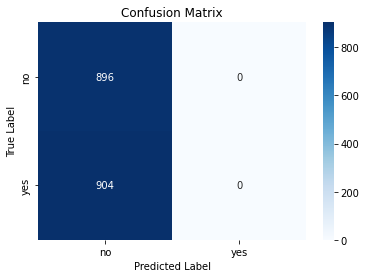

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions for the test data
y_pred = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels for the test data
y_true = test_generator.classes

# Get the class labels from the data generator
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


SVM Classifier

In [ ]:
from sklearn import svm

# Extract features using CNN model
train_features = cnn_model.predict(train_images)
test_features = cnn_model.predict(test_images)
validation_features = cnn_model.predict(validation_images)

251/450 [===============>..............] - ETA: 5:16

KeyboardInterrupt: ignored

In [ ]:
from sklearn.utils import shuffle

# Initialize empty lists to store training and validation accuracies
train_accs = []
val_accs = []

# Train SVM classifier using CNN features
clf = svm.SVC()

for epoch in range(EPOCHS):
    # Shuffle the training features and labels before each epoch
    train_features, train_labels = shuffle(train_features, train_labels)

    # Train the SVM classifier on the shuffled data
    clf.fit(train_features, train_labels)

    # Calculate the training and validation accuracies
    train_acc = clf.score(train_features, train_labels)
    val_acc = clf.score(validation_features, validation_labels)

    # Append the accuracies to the lists
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Print epoch number and accuracy values
    print(f"Epoch {epoch+1}: Train acc = {train_acc:.4f}, Val acc = {val_acc:.4f}")


Epoch 1: Train acc = 0.9981, Val acc = 0.9700
Epoch 2: Train acc = 0.9981, Val acc = 0.9700
Epoch 3: Train acc = 0.9981, Val acc = 0.9700
Epoch 4: Train acc = 0.9981, Val acc = 0.9700
Epoch 5: Train acc = 0.9981, Val acc = 0.9700
Epoch 6: Train acc = 0.9981, Val acc = 0.9700
Epoch 7: Train acc = 0.9981, Val acc = 0.9700
Epoch 8: Train acc = 0.9981, Val acc = 0.9700
Epoch 9: Train acc = 0.9981, Val acc = 0.9700
Epoch 10: Train acc = 0.9981, Val acc = 0.9700
Epoch 11: Train acc = 0.9981, Val acc = 0.9700
Epoch 12: Train acc = 0.9981, Val acc = 0.9700
Epoch 13: Train acc = 0.9981, Val acc = 0.9700
Epoch 14: Train acc = 0.9981, Val acc = 0.9700
Epoch 15: Train acc = 0.9981, Val acc = 0.9700
Epoch 16: Train acc = 0.9981, Val acc = 0.9700
Epoch 17: Train acc = 0.9981, Val acc = 0.9700
Epoch 18: Train acc = 0.9981, Val acc = 0.9700
Epoch 19: Train acc = 0.9981, Val acc = 0.9700
Epoch 20: Train acc = 0.9981, Val acc = 0.9700
Epoch 21: Train acc = 0.9981, Val acc = 0.9700
Epoch 22: Train acc = 

In [ ]:
import pickle
# Save SVM classifier
with open('/content/gdrive/MyDrive/MajorProject/br35hdataset/svm_model_1.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [ ]:
import pickle
# Load SVM classifier
with open('/content/gdrive/MyDrive/MajorProject/br35hdataset/svm_model_1.pkl', 'rb') as f:
    svm_classifier = pickle.load(f)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import svm

classes = ['no', 'yes']

# Predict the labels for the test data
pred_labels = clf.predict(test_images)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Print the confusion matrix
print('Confusion matrix:')
print(cm)


NameError: ignored